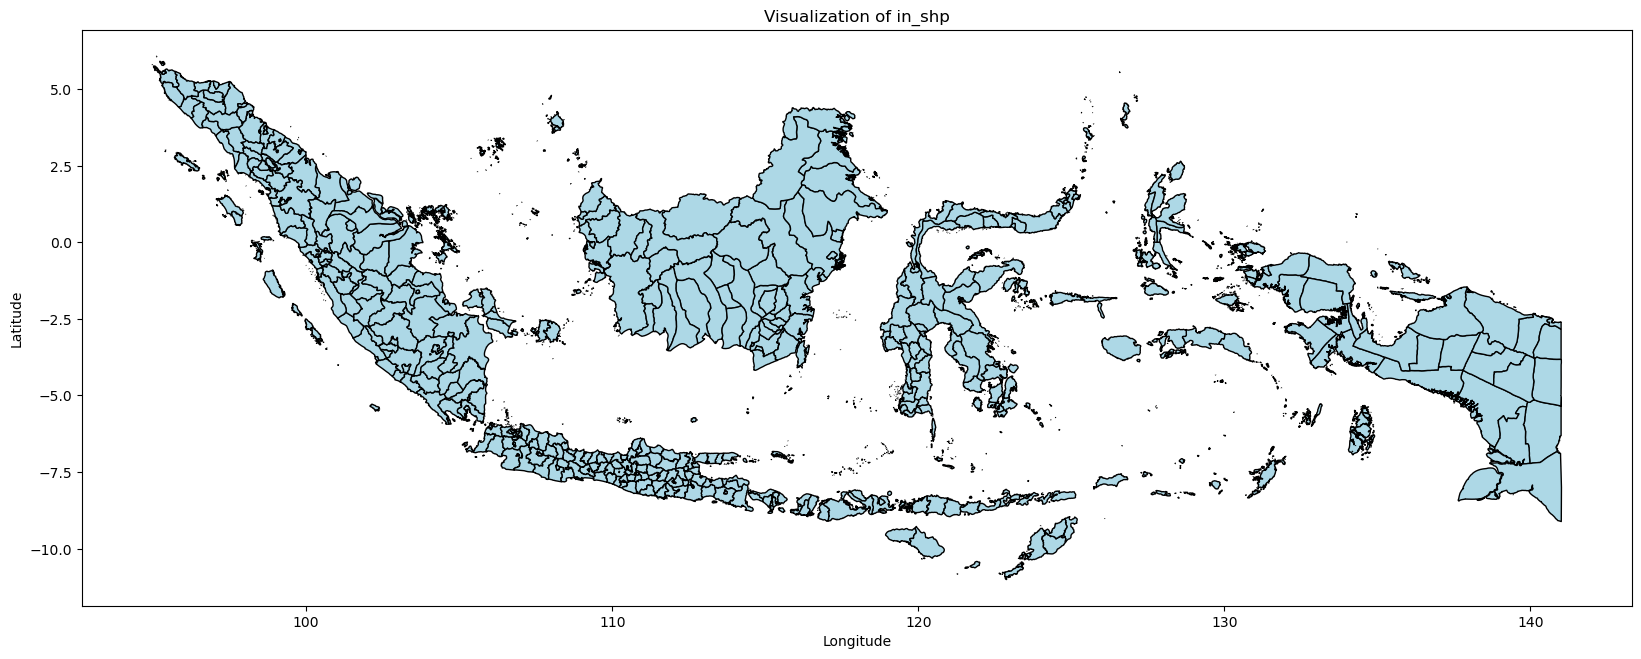

In [ ]:
# Import basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os 
from pathlib import Path
import unicodedata
import sys
from tqdm import tqdm  
import re

# Define project root based on script location
def find_project_root(current: Path, marker: str = ".git"):
    for parent in current.resolve().parents:
        if (parent / marker).exists():
            return parent
    return current.resolve()  # fallback

PROJECT_ROOT = find_project_root(Path.cwd())
RAW_DIR = PROJECT_ROOT / "data" / "raw"
INTERIM_DIR = PROJECT_ROOT / "data" / "interim"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
EXTERNAL_DIR = PROJECT_ROOT / "data" / "external"

# Load in excel file and define future save directory
xls_path = RAW_DIR / "IN_DENGUE" / "DENGUE MONTHLY DATA (Updated).xlsx"
# Read in Indonesia shapefile
in_shp = EXTERNAL_DIR / "in_shp" / "Simplify_IDN"
# Read in Indonesia shapefile
in_shp = gpd.read_file(in_shp)

# Check if the shapefile was loaded correctly
fig, ax = plt.subplots(figsize=(20, 10))
in_shp.plot(ax=ax, color='lightblue', edgecolor='black')
plt.title("Visualization of in_shp")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

This section loads in the multilevel index and renames them as data analysis ready format.

In [14]:
def parse_and_clean_sheet(excel_file, sheet_name):
    """Parses and cleans a single sheet from the Excel file."""
    df_raw = pd.read_excel(excel_file, sheet_name=sheet_name, header=None)

    # Fix "Province" error
    if df_raw.iloc[0, 3] == "Province":
        df_raw.iloc[0, 3] = "January"

    # Build combined headers
    headers = [
        f"{str(df_raw.iloc[0, col]).strip()} - {str(df_raw.iloc[1, col]).strip()}"
        if pd.notna(df_raw.iloc[0, col]) and pd.notna(df_raw.iloc[1, col])
        else str(df_raw.iloc[0, col]).strip()
        if pd.notna(df_raw.iloc[0, col])
        else str(df_raw.iloc[1, col]).strip()
        if pd.notna(df_raw.iloc[1, col])
        else f"Unnamed_{col}"
        for col in range(df_raw.shape[1])
    ]

    # Set new headers and return DataFrame
    df = df_raw.iloc[2:].copy()
    df.columns = headers
    return df

def rename_infection_columns(df):
    """Renames columns containing month names or '0' followed by 'Death' to 'Infection_MonthNumber'."""
    month_order = ["January", "February", "March", "April", "May", "June",
                   "July", "August", "September", "October", "November", "December"]
    new_columns = {}
    infection_month_counter = 1

    for i, col in enumerate(df.columns):
        found_match = False
        # Check for month names
        for j, month in enumerate(month_order):
            if month in col:
                new_columns[col] = f"Infection_{j+1}"
                found_match = True
                break
        
        # Check for '0' followed by 'Death'
        if not found_match and '0' in col and (i + 1) < len(df.columns) and 'Death' in df.columns[i + 1]:
            new_columns[col] = f"Infection_{infection_month_counter}"
            infection_month_counter += 1
            found_match = True
        
        # If no specific match, keep original column name
        if not found_match:
            new_columns[col] = col

    return df.rename(columns=new_columns)

def rename_death_columns(df):
    """Renames 'Death' columns following 'Infection_X' to 'Death_X'."""
    new_columns = []
    death_month = 1
    i = 0
    while i < len(df.columns):
        col = df.columns[i]
        
        if col.startswith('Infection_') and (i + 1) < len(df.columns) and 'Death' in df.columns[i + 1]:
            new_columns.append(col) # Add the Infection column
            new_columns.append(f'Death_{death_month}') # Add the corresponding Death column
            i += 1 # Skip the original 'Death' column
            death_month += 1
        else:
            new_columns.append(col)
        i += 1
    df.columns = new_columns
    return df

def standardize_total_count_column(df):
    """Renames 'Total Case Count' and 'Total_Death'."""
    df = df.rename(columns={'Total Case Count': 'Total_Infection','Total Death':'Total_Death'})
    return df

def process_excel_sheets_and_create_global_variables(xls_path, years):
    """
    Processes all sheets in the given Excel file for the specified years
    and creates individual global variable DataFrames named df_{sheetname}.

    Args:
        xls_path (str): Path to the Excel file.
        years (list or range): Years corresponding to the sheet names.
    """
    excel_file = pd.ExcelFile(xls_path)

    for year in years:
        sheet_name = str(year)
        if sheet_name in excel_file.sheet_names:
            df = parse_and_clean_sheet(excel_file, sheet_name)
            print(f'Parsed and cleaned columns: {list(df.columns)}')
            df = rename_infection_columns(df)
            print(f'Renamed infection columns: {list(df.columns)}')  # Rename infection columns FIRST
            df = rename_death_columns(df)
            print(f'Renamed death columns: {list(df.columns)}')    # Then rename death columns
            df = standardize_total_count_column(df)
            print(f'Renamed total counts columns: {list(df.columns)}')

            # Drop empty unnamed columns
            unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
            cols_to_drop = [col for col in unnamed_cols if df[col].isnull().all()]
            df.drop(columns=cols_to_drop, inplace=True)
            print(f"Sheet '{sheet_name}': Dropped columns {cols_to_drop}")

            if 'Unnamed_35' in df.columns:
                df.drop(columns=['Unnamed_35'], inplace=True)
                print(f"Sheet '{sheet_name}': Dropped column 'Unnamed_35'")

            # Create global variable
            globals()[f"df_{sheet_name}"] = df
            print(f"Created global DataFrame: df_{sheet_name} of shape {df.shape}")
            print("="*15)
        else:
            print(f"Sheet '{sheet_name}' not found in the Excel file.")

# Example Usage (assuming you have an Excel file at 'your_excel_file.xlsx')
# xls_path = 'your_excel_file.xlsx'
years_to_process = range(2010, 2024)
process_excel_sheets_and_create_global_variables(xls_path, years_to_process)

Parsed and cleaned columns: ['Province', 'City', 'City/Regency', 'January - Case Count', 'Death', 'February - Case Count', 'Death', 'March - Case Count', 'Death', 'April - Case Count', 'Death', 'May - Case Count', 'Death', 'June - Case Count', 'Death', 'July - Case Count', 'Death', 'August - Case Count', 'Death', 'September - Case Count', 'Death', 'October - Case Count', 'Death', 'November - Case Count', 'Death', 'December - Case Count', 'Death', 'Total Case Count', 'Total Death', 'IR per 100000', 'CFR', 'Population']
Renamed infection columns: ['Province', 'City', 'City/Regency', 'Infection_1', 'Death', 'Infection_2', 'Death', 'Infection_3', 'Death', 'Infection_4', 'Death', 'Infection_5', 'Death', 'Infection_6', 'Death', 'Infection_7', 'Death', 'Infection_8', 'Death', 'Infection_9', 'Death', 'Infection_10', 'Death', 'Infection_11', 'Death', 'Infection_12', 'Death', 'Total Case Count', 'Total Death', 'IR per 100000', 'CFR', 'Population']
Renamed death columns: ['Province', 'City', 'Cit

This section deals with erroneous geographic location ID (Strings for Administrative Levels, Integer for ID_2)

In [4]:
'''First cleanup problematic strings in Indonesia shapefile'''
# Step 1: Clean up \r, \n, \t and extra spaces from

def clean_string(s):
    if isinstance(s, str):
        s = unicodedata.normalize("NFKD", s)  # Normalize Unicode
        s = s.encode("ascii", "ignore").decode("utf-8") # Remove non-ASCII
        s = re.sub(r"[^\w\s]", "", s) # Remove punctuation
        s = re.sub(r"\s+", " ", s).strip() # Normalize whitespace
        return s.lower() # Optional: lowercase for case-insensitive match
    return s

in_shp['NAME_2'] = (
    in_shp['NAME_2']
    .str.replace(r'[\r\n\t]+', ' ', regex=True)  # Replace line breaks/tabs with space
    .str.strip()                                 # Remove leading/trailing spaces
)
# Step 2: Deduplicate repeated phrases
in_shp['NAME_2'] = in_shp['NAME_2'].apply(
    lambda x: ' '.join(dict.fromkeys(x.split()))
)

In [17]:
# Define administrative levels for each region
sumatra = ['Aceh', 'Bangka-Belitung', 'Bengkulu', 'Jambi', 'Kepulauan Riau', 'Lampung', 'Sumatera Barat', 'Sumatera Selatan', 'Sumatera Utara']
nusa_tenggara = ['Bali', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur']
java = ['Banten', 'Jawa Barat', 'Jawa Tengah', 'Jawa Timur', 'Riau', 'Yogyakarta', 'Jakarta Raya']
sulawesi = ['Gorontalo', 'Bengkulu', 'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tengah', 'Sulawesi Tenggara', 'Sulawesi Utara']
kalimantan = ['Kalimantan Barat', 'Kalimantan Selatan', 'Kalimantan Tengah', 'Kalimantan Timur', 'Kalimantan Utara']
maluku_islands = ['Maluku Utara', 'Maluku']
papua = ['Papua', 'Irian Jaya Barat']

# Create a region lookup dictionary for provinces
region_mapping = {}
region_mapping.update({province: 'Sumatra' for province in sumatra})
region_mapping.update({province: 'Nusa Tenggara' for province in nusa_tenggara})
region_mapping.update({province: 'Java' for province in java})
region_mapping.update({province: 'Sulawesi' for province in sulawesi})
region_mapping.update({province: 'Kalimantan' for province in kalimantan})
region_mapping.update({province: 'Maluku Islands' for province in maluku_islands})
region_mapping.update({province: 'Papua' for province in papua})

# Reduce shapefile to relevant columns and assign Region
shapefile_reduced = in_shp[['NAME_1', 'NAME_2', 'ENGTYPE_2', 'ID_2']].copy()
shapefile_reduced['Region'] = shapefile_reduced['NAME_1'].map(region_mapping).fillna('Unknown')

# Create a dictionary lookup for (NAME_1, NAME_2, ENGTYPE_2) → (ID_2, Region)
lookup_dict = {
    (row.NAME_1, row.NAME_2, row.ENGTYPE_2): (row.ID_2, row.Region)
    for _, row in shapefile_reduced.iterrows()
}

# Create a province-based region lookup (already created as region_mapping)
province_region_mapping = region_mapping

# --- Process dataframes from 2010 to 2023 ---
updated_dataframes_flexible = []
problematic_rows_flexible = []

for year in range(2010, 2024):
    df_name = f'df_{year}'
    if df_name in locals() or df_name in globals():
        globals()[df_name] = df.copy()
    else:
        print(f"Warning: Dataframe '{df_name}' not found. Skipping.")
        continue

    df['ID_2'] = None
    df['Region'] = None

    for index, row in df.iterrows():
        # First, try to match the full key
        key = (row['Province'], row['City'], row['City/Regency'])
        if key in lookup_dict:
            df.loc[index, 'ID_2'], df.loc[index, 'Region'] = lookup_dict[key]
        else:
            # If no full match, try matching by Province for Region
            if row['Province'] in province_region_mapping:
                df.loc[index, 'Region'] = province_region_mapping[row['Province']]
                df.loc[index, 'ID_2'] = None # ID_2 can't be assigned without a full match

                # Identify mismatches for reporting
                mismatches = []
                # Check if the province exists in the shapefile data at all for potential mismatches
                province_in_shp = any(shp_key[0] == row['Province'] for shp_key in lookup_dict.keys())

                if province_in_shp:
                    # Look for specific mismatches if the province itself is present in shapefile
                    found_city_match = False
                    found_type_match = False
                    for shp_key in lookup_dict.keys():
                        if row['Province'] == shp_key[0]:
                            if row['City'] == shp_key[1]:
                                found_city_match = True
                            if row['City/Regency'] == shp_key[2]:
                                found_type_match = True
                    if not found_city_match:
                        mismatches.append("City")
                    if not found_type_match:
                        mismatches.append("City/Regency Type")

                    if mismatches: # Only add to problematic if there are actual mismatches
                        problematic_row_data = row.to_dict()
                        problematic_row_data['Mismatch(es)'] = ", ".join(mismatches) + " (Partial Province Match)"
                        problematic_rows_flexible.append(problematic_row_data)
                else: # Province not found in shapefile at all
                    problematic_row_data = row.to_dict()
                    problematic_row_data['Mismatch(es)'] = "Province not found in shapefile data"
                    problematic_rows_flexible.append(problematic_row_data)

            else:
                # If no province match at all
                problematic_row_data = row.to_dict()
                problematic_row_data['Mismatch(es)'] = "Province not found in region mapping"
                problematic_rows_flexible.append(problematic_row_data)

    updated_dataframes_flexible.append(df.copy())

problematic_df_flexible = pd.DataFrame(problematic_rows_flexible)

print("\n--- Processing Complete ---")
print("Updated dataframes are in 'updated_dataframes_flexible'.")
print("Details of problematic rows are in 'problematic_df_flexible'.")


--- Processing Complete ---
Updated dataframes are in 'updated_dataframes_flexible'.
Details of problematic rows are in 'problematic_df_flexible'.


In [19]:
# Clean and correct Jawa Timur, Blitar only
for year in range(2010, 2024):
    df = globals().get(f'df_{year}')
    if df is not None and 'City' in df.columns and 'Province' in df.columns:
        # Identify Blitar in Jawa Timur with potential erroneous encoding
        mask = (df['Province'] == 'Jawa Timur') & (df['City'].str.contains('Blitar'))

        # Apply cleaning only to those rows
        df.loc[mask, 'City'] = (
            df.loc[mask, 'City']
            .str.replace('_x000D_', '', regex=False)
            .str.strip()
        )

        # Set ID_2 = 147 for the corrected Blitar row
        if 'ID_2' in df.columns:
            df.loc[mask, 'ID_2'] = 147

'''Papua Jayapura is considered either a Regency or a Municipality.'''
for year in range(2010, 2024):
    df = globals().get(f'df_{year}')
    if df is not None and 'City' in df.columns:
        df.loc[(df['City'] == 'Jayapura') & (df['Province'] == 'Papua'), 'ID_2'] = 296


In [21]:
'''Mapping ID_2 and Region to entries of dengue fever dataframes'''
# Step 1: Create a mapping from ID_2 to Region
id2_to_region = shapefile_reduced.set_index('ID_2')['Region'].to_dict()

# Step 2: Apply this mapping to all your updated dataframes
for df in updated_dataframes_flexible:
    df['Region'] = df['ID_2'].map(id2_to_region).fillna('Unknown')  # Re-map based on the final ID_2

# Find any unknown Region assignments
unmatched_ids = set()
for df in updated_dataframes_flexible:
    unmatched_ids.update(df[df['Region'] == 'Unknown']['ID_2'].dropna().unique())

if unmatched_ids:
    print("Unmatched ID_2 values:", unmatched_ids)
else:
    print("All ID_2 values matched with a Region.")

'''Assign Region value to each polygon in the Indonesia shapefile.'''
in_shp['Region'] = in_shp['ID_2'].map(id2_to_region).fillna('Unknown')

# Find any unknown Region assignments in in_shp
unmatched_ids_in_shp = in_shp[in_shp['Region'] == 'Unknown']['ID_2'].dropna().unique()

if unmatched_ids_in_shp.size > 0:
    print("Unmatched ID_2 values in 'in_shp':", unmatched_ids_in_shp)
else:
    print("All ID_2 values in 'in_shp' matched with a Region.")

All ID_2 values matched with a Region.
All ID_2 values in 'in_shp' matched with a Region.


In [ ]:
# At this point, the in_shp has been updated with Region information and can be saved or used for further analysis.
# in_shp.to_file(r'D:\Projects\TMU\gee_dengue\data\external\in_shp_new\in_shp_new')

In [22]:
'''Process additionally problematic rows.'''
provinces = [
    'Aceh', 'Bali', 'Bangka-Belitung', 'Banten', 'Bengkulu',
    'Gorontalo', 'Irian Jaya Barat', 'Jakarta Raya', 'Jambi',
    'Jawa Barat', 'Jawa Tengah', 'Jawa Timur', 'Kalimantan Barat',
    'Kalimantan Selatan', 'Kalimantan Tengah', 'Kalimantan Timur',
    'Kalimantan Utara', 'Kepulauan Riau', 'Lampung', 'Maluku Utara',
    'Maluku', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur', 'Papua',
    'Riau', 'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tengah',
    'Sulawesi Tenggara', 'Sulawesi Utara', 'Sumatera Barat',
    'Sumatera Selatan', 'Sumatera Utara', 'Yogyakarta'
]

if 'NAME_1' not in in_shp.columns or 'ID_2' not in in_shp.columns:
    print("Error: in_shp is missing required columns ('NAME_1' or 'ID_2').")
else:
    for year in range(2010, 2024):
        df_name = f'df_{year}'
        df = globals().get(df_name)

        if df is None:
            print(f"{df_name} not found.")
            continue

        if 'Province' not in df.columns or 'ID_2' not in df.columns:
            print(f"Error: {df_name} is missing required columns ('Province' or 'ID_2').")
            continue

        print(f"\nChecking {df_name}...")
        updated = False

        for province in provinces:
            province = province.strip()
            shp_subset = in_shp[in_shp['NAME_1'].str.strip() == province].copy()
            shp_ids = shp_subset['ID_2'].dropna().astype(int).unique().tolist()  # Ensure it's a list

            # Identify rows in the current year's DataFrame where 'Province' matches and 'ID_2' is NaN
            mask = (df['Province'].str.strip() == province) & (df['ID_2'].isna())

            if len(shp_ids) > 0 and mask.any():
                # Assuming a one-to-one mapping or that the first ID_2 found is the correct one to fill NaNs
                id_to_fill = shp_ids[0]
                df.loc[mask, 'ID_2'] = id_to_fill
                updated = True
                print(f"  Filled NaN ID_2 with {id_to_fill} for province '{province}' in {df_name}")
            elif mask.any() and len(shp_ids) == 0:
                print(f"  No ID_2 found in shapefile for province '{province}' to fill NaN values in {df_name}")
            else:
                print(f"  No NaN ID_2 found for '{province}' in {df_name}")

        if updated:
            globals()[df_name] = df
            print(f"===== Finished updating {df_name}.=====")
        else:
            print(f"✅ No updates needed for {df_name}.")


Checking df_2010...
  No NaN ID_2 found for 'Aceh' in df_2010
  No NaN ID_2 found for 'Bali' in df_2010
  No NaN ID_2 found for 'Bangka-Belitung' in df_2010
  No NaN ID_2 found for 'Banten' in df_2010
  No NaN ID_2 found for 'Bengkulu' in df_2010
  No NaN ID_2 found for 'Gorontalo' in df_2010
  No NaN ID_2 found for 'Irian Jaya Barat' in df_2010
  No NaN ID_2 found for 'Jakarta Raya' in df_2010
  No NaN ID_2 found for 'Jambi' in df_2010
  No NaN ID_2 found for 'Jawa Barat' in df_2010
  No NaN ID_2 found for 'Jawa Tengah' in df_2010
  Filled NaN ID_2 with 144 for province 'Jawa Timur' in df_2010
  No NaN ID_2 found for 'Kalimantan Barat' in df_2010
  No NaN ID_2 found for 'Kalimantan Selatan' in df_2010
  No NaN ID_2 found for 'Kalimantan Tengah' in df_2010
  No NaN ID_2 found for 'Kalimantan Timur' in df_2010
  No NaN ID_2 found for 'Kalimantan Utara' in df_2010
  No NaN ID_2 found for 'Kepulauan Riau' in df_2010
  No NaN ID_2 found for 'Lampung' in df_2010
  No NaN ID_2 found for 'Ma

In [23]:
# After the main loop ends
for year in range(2010, 2024):
    df_name = f'df_{year}'
    df = globals().get(df_name)

    if df is None:
        print(f"{df_name} not found during final validation.")
        continue

    if df['ID_2'].isna().any():
        missing_count = df['ID_2'].isna().sum()
        print(f" {df_name} still has {missing_count} rows with missing ID_2.")
    else:
        print(f" [v] All rows in {df_name} have non-null ID_2.")

 [v] All rows in df_2010 have non-null ID_2.
 [v] All rows in df_2011 have non-null ID_2.
 [v] All rows in df_2012 have non-null ID_2.
 [v] All rows in df_2013 have non-null ID_2.
 [v] All rows in df_2014 have non-null ID_2.
 [v] All rows in df_2015 have non-null ID_2.
 [v] All rows in df_2016 have non-null ID_2.
 [v] All rows in df_2017 have non-null ID_2.
 [v] All rows in df_2018 have non-null ID_2.
 [v] All rows in df_2019 have non-null ID_2.
 [v] All rows in df_2020 have non-null ID_2.
 [v] All rows in df_2021 have non-null ID_2.
 [v] All rows in df_2022 have non-null ID_2.
 [v] All rows in df_2023 have non-null ID_2.


This section deals with erroneous infection count or death data. (Integer-type)

In [24]:
def is_dubious(value):
    """Checks if a value is null, a non-zero float, negative, or a string that cannot be converted to an integer."""
    if pd.isna(value):
        return 'Is Null'
    if isinstance(value, float) and value != 0 and value == int(value):
        return None
    if isinstance(value, float) and value != 0:
        return 'Is Non-Zero Float'
    if isinstance(value, (int, np.integer)) and value < 0:
        return 'Is Negative'
    if isinstance(value, str):
        try:
            int(value)
            return None
        except ValueError:
            return 'Cannot Convert to Integer'
    return None  # If none of the above, it's not dubious

def normalize_value(value):
    """Converts dubious values to appropriate numerical form."""
    if pd.isna(value) or (isinstance(value, (int, np.integer)) and value < 0):
        return 0
    if isinstance(value, float) and value != 0:
        return max(0, int(round(value)))  # Closest positive integer
    if isinstance(value, str):
        try:
            return int(value)
        except ValueError:
            return 0
    if isinstance(value, (int, np.integer)):
        return value
    return 0  # Default fallback

def find_inconsistent_infection_death(df):
    """
    Identifies rows with dubious monthly infection/death values, normalizes them,
    checks for inconsistencies, and returns a processed DataFrame.

    Returns:
      - dubious_rows: rows with one or more dubious cells (includes 'Problem_Columns', 'Dubious_Details', 'Year')
      - normalized_discrepancies: rows where totals don't match sum of normalized monthly values (includes 'Discrepancy_Details', 'Year')
      - processed_df: input DataFrame with normalized monthly values and computed totals
    """
    infection_cols = [f'Infection_{i}' for i in range(1, 13)]
    death_cols = [f'Death_{i}' for i in range(1, 13)]
    all_cols = infection_cols + death_cols

    dubious_entries = []
    inconsistent_rows = []
    processed_df = df.copy()

    for idx, row in df.iterrows():
        problem_columns = []
        dubious_details = {}
        normalized_infection_values = []
        normalized_death_values = []

        # Normalize infection values
        for col in infection_cols:
            val = row[col]
            dubiousness = is_dubious(val)
            if dubiousness:
                problem_columns.append(col)
                dubious_details[col] = dubiousness
            normalized_val = normalize_value(val)
            processed_df.at[idx, col] = normalized_val
            normalized_infection_values.append(normalized_val)

        # Normalize death values
        for col in death_cols:
            val = row[col]
            dubiousness = is_dubious(val)
            if dubiousness:
                problem_columns.append(col)
                dubious_details[col] = dubiousness
            normalized_val = normalize_value(val)
            processed_df.at[idx, col] = normalized_val
            normalized_death_values.append(normalized_val)

        # Track dubious values
        if problem_columns:
            full_row = row.copy()
            full_row['Year'] = row['Year']
            full_row['Problem_Columns'] = ', '.join(problem_columns)
            full_row['Dubious_Details'] = [f"Column '{col}': '{reason}'" for col, reason in dubious_details.items()]
            dubious_entries.append(full_row)

        # Calculate computed totals
        infection_sum = sum(normalized_infection_values)
        death_sum = sum(normalized_death_values)

        processed_df.at[idx, 'Computed_Total_Infection'] = infection_sum
        processed_df.at[idx, 'Computed_Total_Death'] = death_sum

        # Compare with reported totals
        try:
            reported_infection = int(float(row['Total_Infection']))
        except (ValueError, TypeError):
            reported_infection = None

        try:
            reported_death = int(float(row['Total_Death']))
        except (ValueError, TypeError):
            reported_death = None

        # If any mismatch, record the row
        if (reported_infection is not None and reported_infection != infection_sum) or \
           (reported_death is not None and reported_death != death_sum):
            full_row = row.copy()
            full_row['Year'] = row['Year']
            full_row['Computed_Infection_Sum'] = infection_sum
            full_row['Computed_Death_Sum'] = death_sum
            discrepancy_details = []
            if reported_infection is not None and reported_infection != infection_sum:
                discrepancy_details.append(f"Total_Infection vs. Computed_Total_Infection: {reported_infection} vs {infection_sum}")
            if reported_death is not None and reported_death != death_sum:
                discrepancy_details.append(f"Total_Death vs. Computed_Total_Death: {reported_death} vs {death_sum}")
            full_row['Discrepancy_Details'] = discrepancy_details
            inconsistent_rows.append(full_row)

    # Create output DataFrames
    dubious_rows = pd.DataFrame(dubious_entries)
    normalized_discrepancies = pd.DataFrame(inconsistent_rows)

    return dubious_rows, normalized_discrepancies, processed_df



# Load DataFrames and Add Year Column
dfs_with_year = []
for year in range(2010, 2024):
    df = globals()[f'df_{year}'].copy()
    df['Year'] = year
    df.reset_index(drop=True, inplace=True)
    dfs_with_year.append(df)

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(dfs_with_year, ignore_index=True)

# Run the diagnostics
dubious_rows, normalized_discrepancies, processed_df = find_inconsistent_infection_death(all_data)

# Calculating incidence rate based on computed infection counts and recorded population
processed_df['Computed_Incidence_Rate'] = processed_df.apply(
    lambda row: (row['Total_Infection'] / row['Population']) * 100000
    if row['Population'] != 0 else 0,
    axis=1)
# --- Output Summary ---
print("Diagnostics for All Years Combined")
print(f"Dubious Rows: {len(dubious_rows)}")
print(f"Discrepancy Rows: {len(normalized_discrepancies)}")
print(f"Cleaned DataFrame Length: {len(processed_df)}")

Diagnostics for All Years Combined
Dubious Rows: 0
Discrepancy Rows: 0
Cleaned DataFrame Length: 6216


In [26]:
# Save rows of information depending on whether values are dubious/discrepant/processed
dubious_rows.to_csv(r"D:\Projects\TMU\gee_dengue\data\processed\dengue_250601_dubious_rows.csv", index=False)
normalized_discrepancies.to_csv(r"D:\Projects\TMU\gee_dengue\data\processed\dengue_250601_normalized_discrepancies.csv", index=False)
processed_df.to_csv(r"D:\Projects\TMU\gee_dengue\data\processed\dengue_250601_processed_df.csv", index=False)
